# Análisis de IPs reportadas como atacantes por SSH

Los ataques por SSH (Secure Shell) son intentos maliciosos de comprometer un sistema a través del protocolo SSH.

![Protocolo SSH](imagenes/ssh.png)

SSH es muy utilizado porque permite establecer una conexión segura y cifrada entre un cliente y un servidor. Pero, establecida la conexión, puede ser también aprovechado por los atacantes.

Al proporcionarse está información no se especificó la naturaleza del ataque, pero entre los más comunes estan los de fuerza bruta.


## Extracción de IPs

Para la realización de este análisis contaba con una lista de IPs que fueron reportadas por conexiones SSH y ataques DDoS. En este caso extraeré las IPs de SSH haciendo uso de bash y Python.

In [213]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/SSH.txt > data/IPsSSH.txt

In [214]:
with open("data/IPsSSH.txt") as ips:
    ipSSH = ips.read()
    
ipSSH = ipSSH.replace("\n", " ").split()
ipSSH

['54.144.244.57',
 '188.166.216.223',
 '220.94.228.162',
 '218.92.0.99',
 '116.193.159.2',
 '109.117.92.13',
 '167.99.112.43',
 '89.248.163.219',
 '143.198.204.177',
 '61.177.173.45',
 '8.222.204.225',
 '220.135.119.188']

### Importamos la implementación de las peticiones a la API

In [215]:
#| code-fold: true
!cp ../app/modulos/abuseIPDB.py modulos/abuseIPDB.py

#Importo los modulos necesarios
from modulos.abuseIPDB import AbuseIPDB
import pandas as pd

In [216]:
#Construyo el objeto
apiAbuse = AbuseIPDB()

In [217]:
#| code-fold: true
import os
import seaborn as sns

In [218]:
#Declaro las keys de la info que devuelve mi implementación de requests
keys = ['esPublica', 'estaEnWhitelist', 'scoreAbuso', 'pais', 'codigoPais', 'isp', 'tipoDeUso', 'ultimoReporte']

diccDf = {'ip' : []}

if os.path.isfile("data/ipSSH.csv"):
    
    df = pd.read_csv("data/ipSSH.csv")
    
else:
    for ip in ipSSH:
        diccDf['ip'].append(ip)
        info = apiAbuse.getInfo(ip)
        for key in keys:
            if key in diccDf:
                diccDf[key].append(info[key])
            else:
                diccDf[key] = [info[key]]

        df = pd.DataFrame(data=diccDf)


In [219]:
#| code-fold: True
#| label: tbl-informaciondevuelta
#| tbl-cap: Columnas del DataFrame construido a partir de la información solicitada del servidor
pd.DataFrame(df.columns)

,0
0,ip
1,esPublica
2,estaEnWhitelist
3,scoreAbuso
4,pais
5,codigoPais
6,isp
7,tipoDeUso
8,ultimoReporte


Listé en @tbl-informaciondevuelta la información que obtuve de la base de datos de AbuseIPDB para cada IP.

In [220]:
df.head(3)

,ip,esPublica,estaEnWhitelist,scoreAbuso,pais,codigoPais,isp,tipoDeUso,ultimoReporte
0,54.144.244.57,True,False,55,NaN,US,Amazon Data Services NoVa,Data Center/Web Hosting/Transit,2023-05-24T06:13:13+00:00
1,188.166.216.223,True,False,100,NaN,SG,DigitalOcean LLC,Data Center/Web Hosting/Transit,2023-05-30T23:00:19+00:00
2,220.94.228.162,True,False,100,NaN,KR,KT Corporation,NaN,2023-05-30T04:16:49+00:00


In [221]:
#| code-fold: true
unameds = [i for i in df.columns if 'Unnamed' in i]
for i in unameds:
    df.drop(i, axis=1, inplace=True)
df.to_csv("data/ipSSH.csv", index=False)

## Índices de abuso

In [222]:
#| label: tbl-indicesssh
#| tbl-cap: Indice de abuso y las veces que se repite
#| code-fold: True
recuento = df["scoreAbuso"].value_counts().to_dict()

pd.DataFrame(data={"Score": list(recuento.keys()), "Reportes": list(recuento.values())})

,Score,Reportes
0,100,11
1,55,1


Como se puede apreciar en la tabla de arriba (@tbl-indicesssh), han sido múltiples veces reportadas por distintos usuarios a lo largo del mundo. Esto hace que la base de datos las califique con un score de abuso alto. Por lo tanto, tenemos la certeza de que son IPs que han sido utilizadas con fines malintencionados previamente y que quien proporcionó los datos no fue el único afectado.

## Análisis de procedencia

In [223]:
#| code-fold: True
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pycountry

df['pais'] = df['codigoPais'].apply(lambda codigo: pycountry.countries.get(alpha_2=codigo).name)
dfgdp = df.copy()
dfgdp['codigoPais'] = df['pais'].apply(lambda nombre: pycountry.countries.search_fuzzy(nombre)[0].alpha_3)

mapa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

::: {.callout-note header=false}
Todas estas librerias utilizan convenciones, por lo cual es importante checkear que esten presentes todos los paises que queremos plotear
:::

In [224]:
print(np.unique(dfgdp["codigoPais"].loc[~dfgdp["codigoPais"].isin(mapa["iso_a3"])]))

['HKG' 'SGP']


Pude notar que tanto Hong Kong, como Singapur no estan representadas en el mapa mundi por ser ciudades. Por ello, debo cargarlas desde otro dataset para marcarla.


En @fig-mapa se presenta el mapamundi con los países o ciudades-estado de donde provienen los ataques pintados de rojo y azul respectivamente.

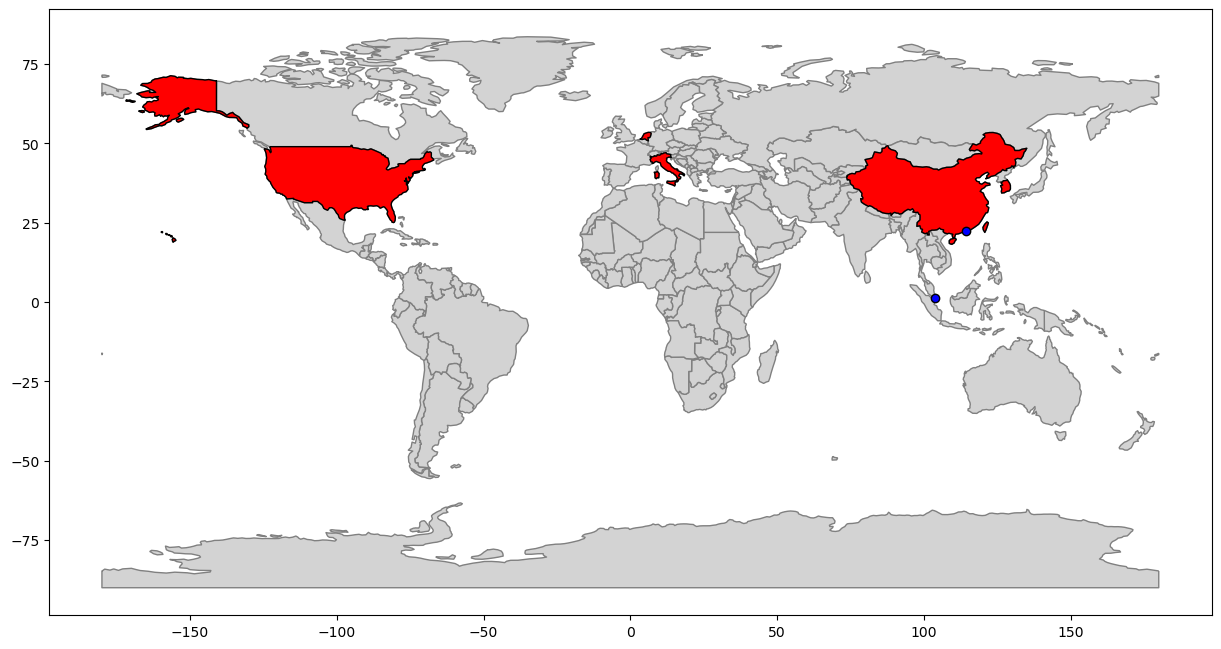

In [225]:
#| label: fig-mapa
#| fig-cap: Mapa con los lugares del que proceden las IPs
#| code-fold: True
paisesMarcados = mapa[mapa['iso_a3'].isin(dfgdp["codigoPais"])]

fig, ax = plt.subplots(figsize=(15, 10))

mapa.plot(ax=ax, edgecolor='grey', color='lightgrey')
paisesMarcados.plot(ax=ax, edgecolor='black', color='red')

ciudades = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

singapur = ciudades[ciudades['name'] == 'Singapore']
hongkong = ciudades[ciudades['name'] == 'Hong Kong']

singapur.plot(ax=ax, edgecolor='black', color='blue')
hongkong.plot(ax=ax, edgecolor='black', color='blue')

plt.show()

En la siguiente figura (@fig-countplot), se puede apreciar el número de IPs que pertenecen a cada uno de los paises, con Singapur encabezando la lista.

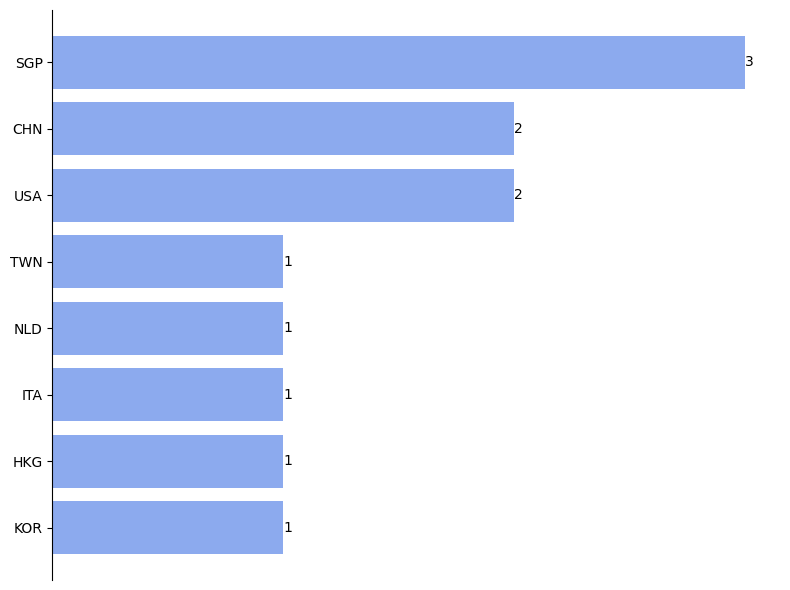

In [226]:
#| label: fig-countplot
#| fig-cap: Recuento del número de reportes
#| code-fold: True
counts = dfgdp["codigoPais"].value_counts().rename_axis('pais').to_frame('counts')
counts.reset_index(level=0, inplace=True)

counts = counts.sort_values(by='counts')

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(counts["pais"], counts['counts'], color='#8caaee')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.spines['left'].set_color('black')

ax.tick_params(axis='y', colors='black')
ax.bar_label(bars, color='black')
plt.tight_layout()
plt.show()

In [227]:
#| code-fold: True
recuento = df["pais"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,Singapore,3
1,United States,2
2,China,2
3,"Korea, Republic of",1
4,Hong Kong,1
5,Italy,1
6,Netherlands,1
7,"Taiwan, Province of China",1


## Análisis de frecuencia
Definí esta tarea para así, tratar de identificar cierto patron asociado a la hora de ataque. 

### Extracción de información

In [228]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/SSH.txt > data/IPsSSH.txt

patron = "[a-z]{3}\/[0-9]{2}\/[0-9]{4}"
!grep -Eo "$patron" data/SSH.txt >> data/IPsSSH.txt

patron = "[0-9]{2}\:[0-9]{2}\:[0-9]{2}"
!grep -Eo "$patron" data/SSH.txt >> data/IPsSSH.txt

In [229]:
with open("data/IPsSSH.txt") as ips:
    data = ips.read()
    data = data.replace("\n", " ").split()

In [230]:
for i in range(int(len(data)/3)):
    data[i] = data[i] + " " + data[int(len(data)/3)+i] + " " + data[(int(len(data)/3))*2+i]
    
data = data[:int(len(data)/3)]

In [231]:
#| code-fold: true
from datetime import datetime, time
diccInfo = {
    "IP": [],
    "Fecha": [],
    "Hora": []
}
eventos = []

for i in data:
    diccInfo["IP"].append(i.split()[0])
    diccInfo["Fecha"].append(i.split()[1])
    mes = 5
    dia = int(i.split()[1].split(sep="/")[1])
    año = int(i.split()[1].split(sep="/")[2])
    h = int(i.split()[2].split(sep=":")[0])
    m = int(i.split()[2].split(sep=":")[1])
    s = int(i.split()[2].split(sep=":")[2])
    diccInfo["Hora"].append(time(hour=int(h), minute=int(m), second=int(s)))
    #diccInfo["Hora"].append(i.split()[2])
    
    eventos.append((i.split()[0],datetime(year=año, month=mes, day=dia, hour=h, minute=m)))
    
dfHora = pd.DataFrame(data=diccInfo)

dfHora["Pais"] = None
for index, row in dfHora.iterrows():
    ip = row["IP"]
    row["Pais"] = df[df['ip'] == ip].iloc[0]['pais']

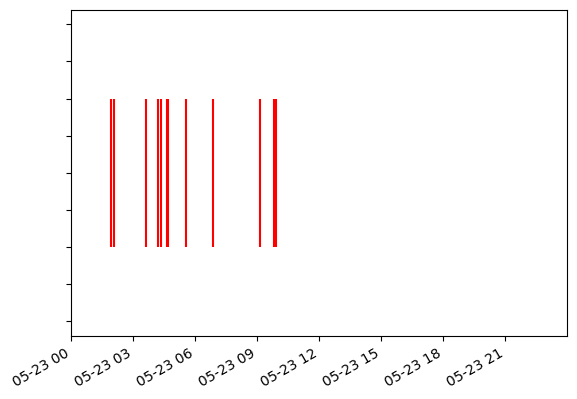

In [232]:
#| warning: false
#| label: fig-eventosssh
#| fig-cap: Visualización de eventos de SSH
fig, ax = plt.subplots()

fecha = [evento[1] for evento in eventos]
etiquetas = [evento[0] for evento in eventos]
ax.eventplot(fecha, lineoffsets=0.1, linelengths=0.1, color='r')
ax.set_ylabel(None)
ax.set_yticklabels([])
ax.set_xlim(datetime(2023, 5, 23, 0, 0), datetime(2023, 5, 23, 23, 59))
fig.autofmt_xdate()


En @fig-eventosssh busqué representar los eventos en función del tiempo yu podemos ver, que el sistema atacado registró estas IPs en un solo día (23 de Mayo) durante horas de la mañana.

## Análisis de ISPs

@tbl-recuentoispssh muestra cuantos de los reportes corresponden a cada uno de los proveedores de internet.

In [233]:
#| code-fold: True
#| label: tbl-recuentoispssh
#| tbl-cap: Número de IPs reportadas de cada ISP
recuento = df["isp"].value_counts().to_dict()

recuento = pd.DataFrame(data={"ISP": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,ISP,Reportes
0,DigitalOcean LLC,3
1,ChinaNet Jiangsu Province Network,2
2,Amazon Data Services NoVa,1
3,KT Corporation,1
4,Pacswitch Globe Telecom Limited,1
5,Vodafone Italia S.p.A.,1
6,FiberXpress BV,1
7,Alibaba.com Singapore E-Commerce Private Limited,1
8,Chunghwa Telecom Co. Ltd.,1


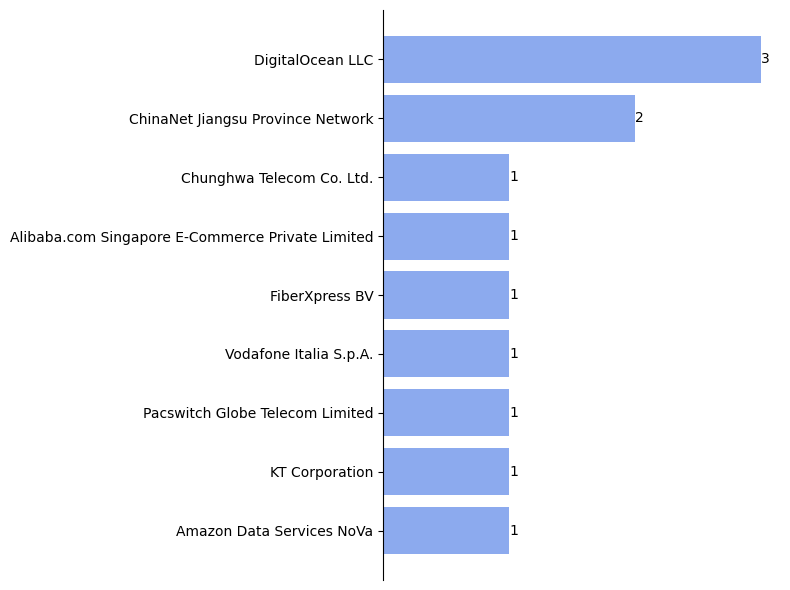

In [234]:
#| label: fig-countplotispssh
#| fig-cap: Recuento del número de veces que fue reportado un ISP
#| code-fold: True
counts = df["isp"].value_counts().rename_axis('isp').to_frame('counts')
counts.reset_index(level=0, inplace=True)

counts = counts.sort_values(by='counts')

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(counts["isp"], counts['counts'], color='#8caaee')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.spines['left'].set_color('black')

ax.tick_params(axis='y', colors='black')
ax.bar_label(bars, color='black')
plt.tight_layout()
plt.show()

@fig-countplotispssh muestra un recuento de los distintos ISPs que tienen asignadas las IPs.

## Análisis de uso

@tbl-usosssh muestra el número de veces que fue declarado cierto uso de una IP.

In [235]:
#| code-fold: True
#| tbl-cap: Recuento de usos declarados por las IPs
#| label: tbl-usosssh
recuento = df["tipoDeUso"].value_counts().to_dict()

recuento = pd.DataFrame(data={"uso": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,uso,Reportes
0,Data Center/Web Hosting/Transit,8
1,Fixed Line ISP,1


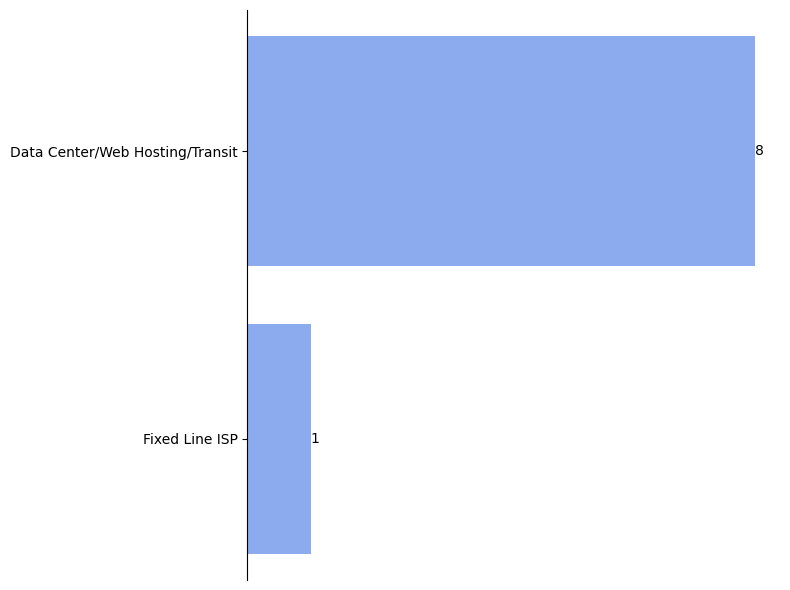

In [236]:
#| label: fig-countplotusossh
#| fig-cap: Recuento de los usos que se les da a las IPs
#| code-fold: True
counts = df["tipoDeUso"].value_counts().rename_axis('uso').to_frame('counts')
counts.reset_index(level=0, inplace=True)

counts = counts.sort_values(by='counts')

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(counts["uso"], counts['counts'], color='#8caaee')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.spines['left'].set_color('black')

ax.tick_params(axis='y', colors='black')
ax.bar_label(bars, color='black')
plt.tight_layout()
plt.show()

@fig-countplotusossh permite visualizar los usos declarados de las IPs declarados.

# Análisis de IPs reportadas por ataque DDoS

Los ataques de denegación de servicio destribuido (DDoS), son intentos de saturar los recursos de un sistema o red, sobrecargando la red con tráfico inesperado. 

![Ilustración ataque DDoS (Cloudflare, 2023)](imagenes/ddos.png)

El foco no es infiltrarse o robar información, sino que busca abrumar y colapsar el objetivo mediante grandes volúmenes de solicitudes. 

La característica distintiva de estos ataques es que son "distribuidos". No se realiza desde una única fuente, sino que se usan múltiples dispositivos como atacantes.

Lo más probable es que quién reporto estas IPs como atacantes haya detectado grandes volumenes o picos de solicitudes en un corto tiempo, levantando sospechas que se podría tratar de atacantes.

Para intentar extraer información de los datos definí el siguiente flujo de trabajo:

## Extracción de información

In [237]:
patron = "[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}"
!grep -Eo "$patron" data/DDOS.txt > data/IPsDDoS.txt

patron = "[a-z]{3}\/[0-9]{2}\/[0-9]{4}"
!grep -Eo "$patron" data/DDOS.txt >> data/IPsDDoS.txt

patron = "[0-9]{2}\:[0-9]{2}\:[0-9]{2}"
!grep -Eo "$patron" data/DDOS.txt >> data/IPsDDoS.txt

In [238]:
with open("data/IPsDDoS.txt") as ips:
    data = ips.read()
    data = data.replace("\n", " ").split()

In [239]:
ips = []
dia = []
hora = []
for i in range(int(len(data)/3)):
    ips.append(data[i])
    dia.append(data[int(len(data)/3)+i])
    hora.append(data[(int(len(data)/3))*2+i])
    data[i] = data[i] + " " + data[int(len(data)/3)+i] + " " + data[(int(len(data)/3))*2+i]
    
data = data[:int(len(data)/3)]

In [240]:
#| code-fold: True
data = pd.DataFrame(data={'ip': ips,
                       'dia': dia,
                       'hora': hora})

apiAbuse = AbuseIPDB()

In [241]:
#Declaro las keys de la info que devuelve mi implementación de requests
keys = ['esPublica', 'estaEnWhitelist', 'scoreAbuso', 'pais', 'codigoPais', 'isp', 'tipoDeUso', 'ultimoReporte']

diccDf = {'ip' : []}

if os.path.isfile("data/ipDDOS.csv"):
    
    df = pd.read_csv("data/ipDDOS.csv")
    
else:
    for ip, i in zip(ips, range(len(ips))):
        clear_output()
        print(f"{i}/{len(ips)}")
        diccDf['ip'].append(ip)
        info = apiAbuse.getInfo(ip)
        for key in keys:
            if key in diccDf:
                diccDf[key].append(info[key])
            else:
                diccDf[key] = [info[key]]

    df = pd.DataFrame(data=diccDf)
    
    
df["hora"] = data["hora"]
df["dia"] = data["dia"]

In [242]:
#| code-fold: true
unameds = [i for i in df.columns if 'Unnamed' in i]
for i in unameds:
    df.drop(i, axis=1, inplace=True)
    
df.to_csv("data/ipDDOS.csv", index=False)

## Índices de abuso

In [264]:
#| code-fold: True
#| label: tbl-indicesddos
#| tbl-cap: Indice de abuso y las veces que se repite
recuento = df["scoreAbuso"].value_counts().to_dict()

pd.DataFrame(data={"Score de abuso": list(recuento.keys()), "Reportes": list(recuento.values())})

,Score de abuso,Reportes
0,0,375
1,2,2
2,10,1


Contrariamente de lo esperado, en @tbl-indicesddos, puedo observar que la gran mayoría tienen un score de abuso nulo y las que no, es muy bajo. 

Lo más simple sería pensar que estas IPs no hayan atacado a más usuarios, pero considero que es poco probable. Por otro lado, podría deberse a la distribución de este ataque, haciendo que en otros sistemas vulnerados pase desapercibido. Otra opción es que el sistema que los reporto tenga mecanismos deficientes para la detección de posibles ataques.

## Análisis de procedencia

In [244]:
import pycountry

In [245]:
df['pais'] = df['codigoPais'].apply(lambda codigo: pycountry.countries.get(alpha_2=codigo).name)
dfgdp = df.copy()
dfgdp['codigoPais'] = df['pais'].apply(lambda nombre: pycountry.countries.search_fuzzy(nombre)[0].alpha_3)

In [246]:
import geopandas as gpd
import matplotlib.pyplot as plt

mapa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [247]:
print(np.unique(dfgdp["codigoPais"].loc[~dfgdp["codigoPais"].isin(mapa["iso_a3"])]))

['HKG']


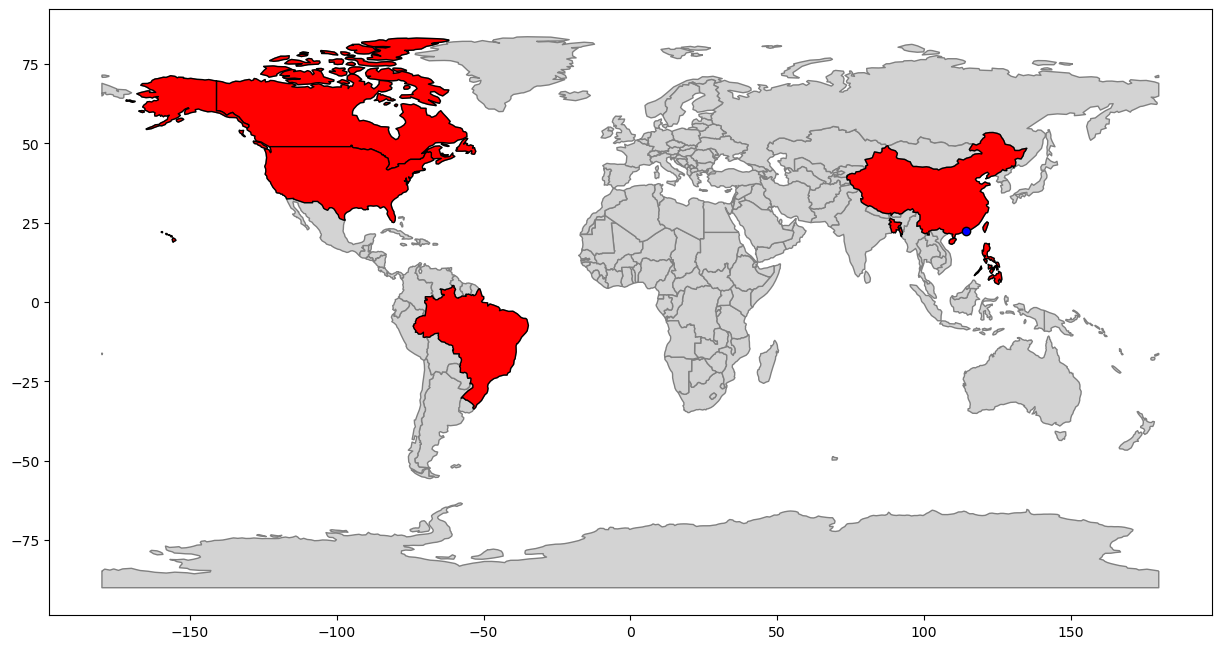

In [248]:
#| label: fig-mapaDDoS
#| fig-cap: Mapa con los lugares del que proceden las IPs
paisesMarcados = mapa[mapa['iso_a3'].isin(dfgdp["codigoPais"])]

fig, ax = plt.subplots(figsize=(15, 10))

mapa.plot(ax=ax, edgecolor='grey', color='lightgrey')
paisesMarcados.plot(ax=ax, edgecolor='black', color='red')

ciudades = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

hongkong = ciudades[ciudades['name'] == 'Hong Kong']

hongkong.plot(ax=ax, edgecolor='black', color='blue')

plt.show()

In [249]:
#| code-fold: true
recuento = df["pais"].value_counts().to_dict()

pd.DataFrame(data={"Pais": list(recuento.keys()), "Reportes": list(recuento.values())})

,Pais,Reportes
0,Hong Kong,174
1,Philippines,118
2,China,75
3,United States,5
4,Canada,3
5,Bangladesh,1
6,"Taiwan, Province of China",1
7,Brazil,1


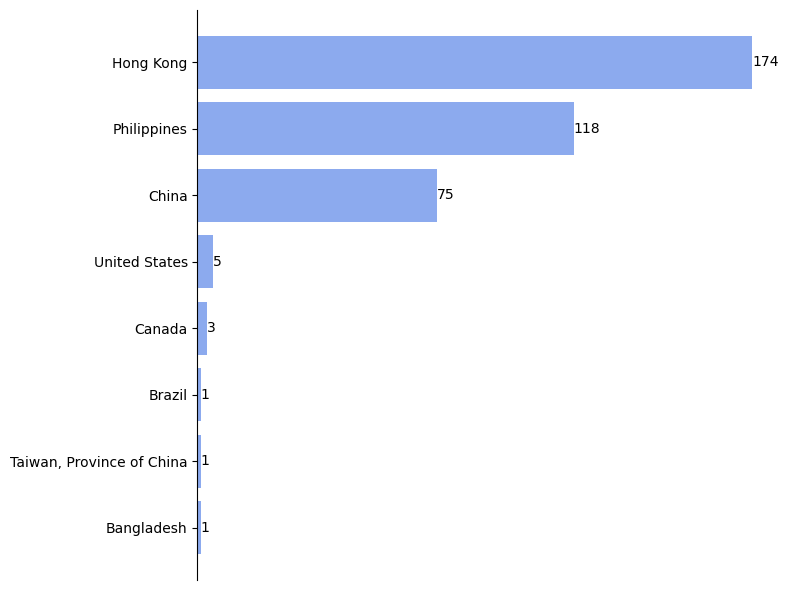

In [250]:
#| label: fig-countplotDDoS
#| fig-cap: Número de reportes por país
#| code-fold: True
counts = df["pais"].value_counts().rename_axis('pais').to_frame('counts')
counts.reset_index(level=0, inplace=True)

counts = counts.sort_values(by='counts')

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(counts["pais"], counts['counts'], color='#8caaee')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.spines['left'].set_color('black')

ax.tick_params(axis='y', colors='black')
ax.bar_label(bars, color='black')
plt.tight_layout()
plt.show()

In [251]:
#| code-fold: True
recuento = dfgdp["codigoPais"].value_counts().to_dict()

dfPlot = pd.DataFrame(data={"codigoPais": list(recuento.keys()), "Reportes": list(recuento.values())})
dfPlot

fig = px.scatter_geo(dfPlot, locations="codigoPais", color="codigoPais", size="Reportes",
                     projection="equirectangular")
fig.write_image("data/plotlyDDoS.png")

## Análisis de frecuencia
Para así poder de tratar de identificar cierto patron asociado a la hora de ataque. 

### Extracción de información

In [ ]:
df.head(3)

In [253]:
eventosDDoS = []
for index, row in df.iterrows():
    fecha = row["dia"].split(sep="/")
    if fecha[0] != 'may':
        print(fecha[0])
    else:
        mes = 5
        
    dia = fecha[1]
    año = fecha[2]
    
    tiempo = row["hora"].split(sep=":")
    hora = tiempo[0]
    minuto = tiempo[1]
    eventosDDoS.append((row["ip"], datetime(int(año), int(mes), int(dia), int(hora), int(minuto))))


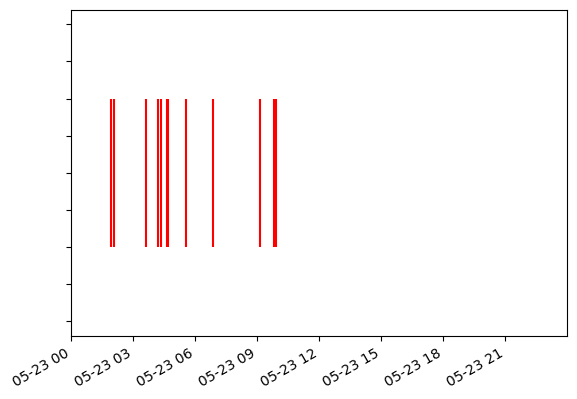

In [254]:
#| warning: false
#| label: fig-eventosDDoS
#| fig-cap: Visualización de eventos de DDoS
fig, ax = plt.subplots()

fecha = [evento[1] for evento in eventos]
etiquetas = [evento[0] for evento in eventos]
ax.eventplot(fecha, lineoffsets=0.1, linelengths=0.1, color='r')
ax.set_ylabel(None)
ax.set_yticklabels([])
ax.set_xlim(datetime(2023, 5, 23, 0, 0), datetime(2023, 5, 23, 23, 59))
fig.autofmt_xdate()

Notar que a comparación de los por SSH parecen menos siendo que son 380 ataques contra 12. Esto es porque son muy seguido.

## Análisis de ISPs

In [255]:
recuento = df["isp"].value_counts().to_dict()

recuento = pd.DataFrame(data={"ISP": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,ISP,Reportes
0,Suniway Group Limited,75
1,Gold Experience Cloud LLC,75
2,Dragon Spirit Investments International Co. Li...,73
3,WTW Hightech Company Inc,67
4,Suniway Telecom,39
5,Suniway Group of Companies Inc.,36
6,Intercontinental Internet Data Corp,1
7,Bell Canada,1
8,Comcast Cable Communications LLC,1
9,Cabo Servicos de Telecomunicacoes Ltda,1


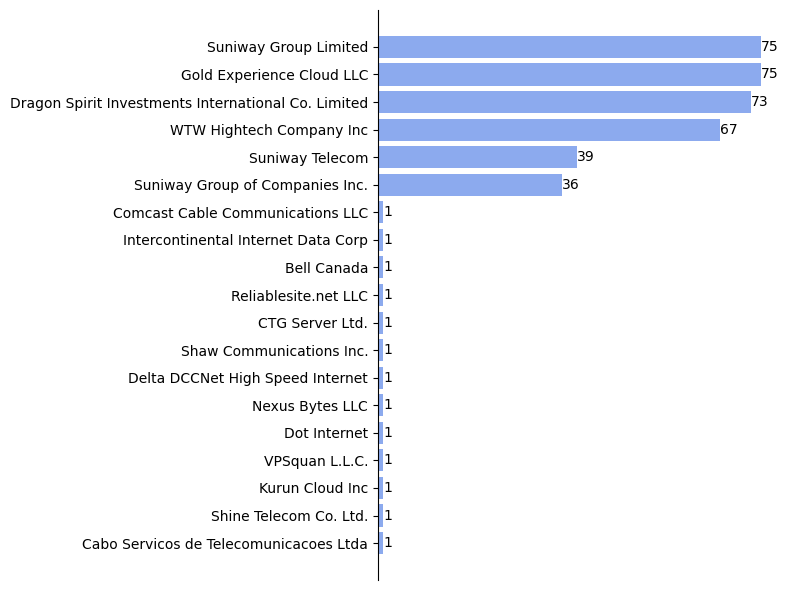

In [256]:
#| label: fig-ispsDDoS
#| fig-cap: Número de veces que se denuncio un ISP por ataque DDoS
counts = df["isp"].value_counts().rename_axis('ISP').to_frame('counts')
counts.reset_index(level=0, inplace=True)

counts = counts.sort_values(by='counts')

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(counts["ISP"], counts['counts'], color='#8caaee')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.spines['left'].set_color('black')

ax.tick_params(axis='y', colors='black')
ax.bar_label(bars, color='black')
plt.tight_layout()
plt.show()


## Análisis de uso

In [257]:
recuento = df["tipoDeUso"].value_counts().to_dict()

recuento = pd.DataFrame(data={"uso": list(recuento.keys()), "Reportes": list(recuento.values())})
recuento

,uso,Reportes
0,Data Center/Web Hosting/Transit,335
1,Fixed Line ISP,42
2,Commercial,1


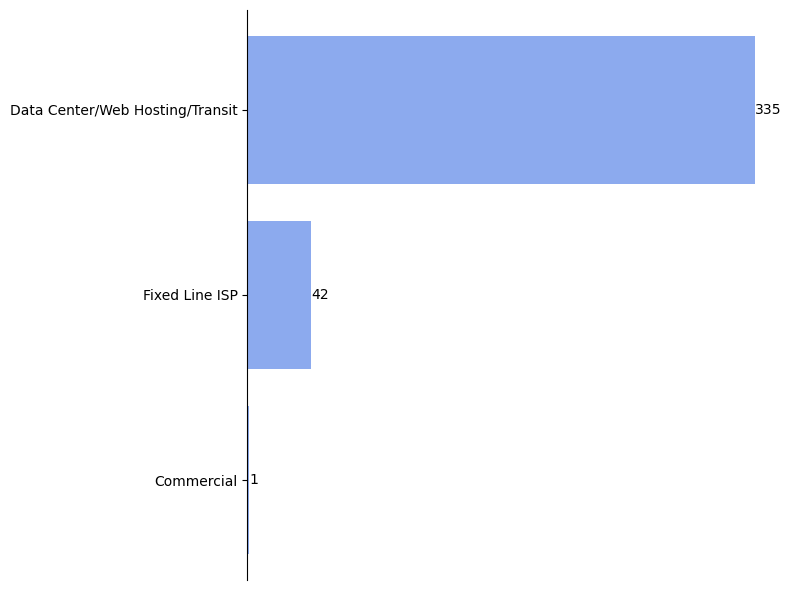

In [258]:
counts = df["tipoDeUso"].value_counts().rename_axis('tipoDeUso').to_frame('counts')
counts.reset_index(level=0, inplace=True)

counts = counts.sort_values(by='counts')

fig, ax = plt.subplots(figsize=(8,6))

bars = plt.barh(counts["tipoDeUso"], counts['counts'], color='#8caaee')

ax.spines[['right', 'top', 'bottom']].set_visible(False) 
ax.xaxis.set_visible(False)

ax.spines['left'].set_color('black')

ax.tick_params(axis='y', colors='black')
ax.bar_label(bars, color='black')
plt.tight_layout()
plt.show()

## ¿Fue un mismo atacante?

In [259]:
import netaddr

def convertirIP(ip):
    return int(netaddr.IPAddress(ip))

In [260]:
#| code-fold: True
datetimes = [evento[1] for evento in eventosDDoS]
dicc = {"ip": df["ip"],
        "datetime": datetimes}

In [261]:
dfClusters = pd.DataFrame(dicc)
dfClusters["datetime"] = dfClusters["datetime"].apply(lambda x: x.utcnow().timestamp())
dfClusters["ipStr"] = dfClusters["ip"]
dfClusters["ip"] = dfClusters["ip"].apply(convertirIP)

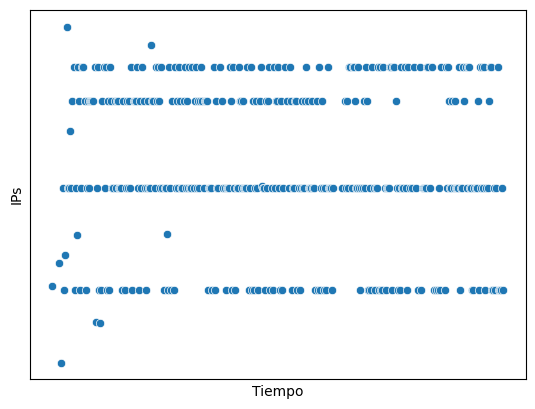

In [262]:
#| fig-cap: IPs vs Tiempo
#| label: fig-usodeips
#| code-fold: True
sns.scatterplot(data=dfClusters,x="datetime", y="ip")
plt.xlabel("Tiempo")
plt.ylabel("IPs")
plt.xticks([])
plt.yticks([])
plt.show()

Como se puede observar en @fig-usodeips pareciese ser que a pesar de que se realizaron reportes en horarios distantes, las IPs no ocupan todo el espectro. Se podría inferir que fue el mismo atacante porque usó IPs en un rango acotado 